In [121]:
!pip install torcheval

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torcheval.metrics.functional import bleu_score

In [124]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import sys
sys.path.append('/content/drive/MyDrive/d2l.ai_implementation/chapter11')
from MTFraEng import MTFraEng
from AttentionEncoderDecoder import AttentionEncoderDecoder
from Training import train

In [126]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/fra-eng/fra.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [127]:
num_train, num_test = 4096, 512
batch_size=128
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
learning_rate=0.005
num_epochs=30

In [128]:
train_data = MTFraEng(PATH, train=True, num_train=num_train, num_test=num_test)
test_data = MTFraEng(PATH, train=False, num_train=num_train, num_test=num_test)

train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

In [129]:
model = AttentionEncoderDecoder(
    len(train_data.src_vocab),
    len(train_data.tgt_vocab),
    embed_size,
    num_hiddens,
    num_layers,
    dropout
).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [130]:
def loss(pred, label, tgt_pad, criterion):
    mask = (label != tgt_pad)
    loss = criterion(pred, label)
    return (loss * mask).sum() / mask.sum()

In [131]:
epochs = 50
criterion = nn.CrossEntropyLoss(reduction='none')
loss_fn = lambda pred, label: loss(pred, label, train_data.tgt_vocab['<pad>'], criterion)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [132]:
train_losses, test_losses = train(
    model,
    DEVICE,
    train_loader,
    test_loader,
    optimizer,
    loss_fn,
    epochs
)

Epoch [1/50]
Train Loss = 4.72101551294326782227
Test Loss = 4.38682508468627929688

Epoch [2/50]
Train Loss = 3.39390246570110321045
Test Loss = 3.98811709880828857422

Epoch [3/50]
Train Loss = 2.90523993223905563354
Test Loss = 3.63159251213073730469

Epoch [4/50]
Train Loss = 2.54153411090373992920
Test Loss = 3.39515846967697143555

Epoch [5/50]
Train Loss = 2.23514589667320251465
Test Loss = 3.36094039678573608398

Epoch [6/50]
Train Loss = 1.96194646507501602173
Test Loss = 3.33272540569305419922

Epoch [7/50]
Train Loss = 1.73476361483335494995
Test Loss = 3.30554157495498657227

Epoch [8/50]
Train Loss = 1.51826009526848793030
Test Loss = 3.27168357372283935547

Epoch [9/50]
Train Loss = 1.33789083361625671387
Test Loss = 3.22336733341217041016

Epoch [10/50]
Train Loss = 1.18531300127506256104
Test Loss = 3.28369659185409545898

Epoch [11/50]
Train Loss = 1.05641996487975120544
Test Loss = 3.22024399042129516602

Epoch [12/50]
Train Loss = 0.94573330320417881012
Test Loss = 3

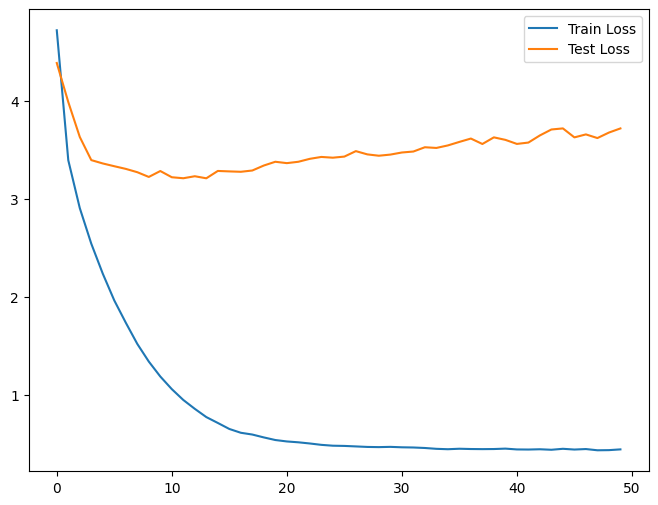

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.show()

In [134]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
arrays= train_data.build(engs, fras)
src, tgt, lable, src_valid_len = arrays

In [135]:
pred = model.predict(src, src_valid_len, train_data.tgt_vocab, 9, DEVICE)

In [136]:
for en, fr, p in zip(engs, fras, pred):
    translation = []
    for token in p:
        word = train_data.tgt_vocab.lookup_token(token)
        if word == '<eos>':
            break
        translation.append(word)

    print(f'{en} => {translation}, bleu: {bleu_score(" ".join(translation), [fr], n_gram=2)}')

go . => ['marche', '.'], bleu: 0.0
i lost . => ["j'ai", 'perdu', '.'], bleu: 1.0
he's calm . => ['il', 'est', 'pété', '.'], bleu: 0.5
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu: 1.0
